Hamza Mhadi

Data Preperation

In [13]:
import numpy as np 
import pandas as pd 
import hvplot.pandas


In [14]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [15]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [16]:
#Load the historical closing prices for Bitcoin 

df2 = pd.read_csv("btc_historic.csv",  index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [17]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [18]:
 df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [19]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [20]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [21]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [22]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [23]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.25287356]
  [0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.31395349]
  [0.24418605]
  [0.40697674]
  [0.52325581]]

 [[0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.32183908]
  [0.24418605]
  [0.40697674]
  [0.52325581]
  [0.25581395]]

 [[0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.32183908]
  [0.25287356]
  [0.40697674]
  [0.52325581]
  [0.25581395]
  [0.38372093]]

 [[0.18390805]
  [0.03448276]
  [0.        ]
  [0.32183908]
  [0.25287356]
  [0.4137931 ]
  [0.52325581]
  [0.25581395]
  [0.38372093]
  [0.30232558]]

 [[0.03448276]
  [0.        ]
  [0.32183908]
  [0.25287356]
  [0.4137931 ]
  [0.52873563]
  [0.25581395]
  [0.38372093]
  [0.30232558]
  [0.53488372]]] 

X_test sample values:
[[[0.36781609]
  [0.43678161]
  [0.34482759]
  [0.45977011]
  [0.45977011]
  [0.40229885]
  [0.39534884]
  [0.37209302]
  [0.3372093 ]
  [0.62790698]]

 [[0.43678161]
  [0.34482759]
  [0.459770

Build and Train LSTM RNN

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [25]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [26]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [27]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [28]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
372/372 [==============================] - 6s 5ms/step - loss: 0.0667
Epoch 2/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0717
Epoch 3/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0743
Epoch 4/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0777
Epoch 5/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0724
Epoch 6/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0735
Epoch 7/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0708
Epoch 8/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0682
Epoch 9/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0642
Epoch 10/10
372/372 [==============================] - 2s 5ms/step - loss: 0.0712


Model Performance

In [29]:
 # Evaluate the model
model.evaluate(X_test, y_test) 

5/5 [==============================] - 1s 3ms/step - loss: 0.1219


0.12194047123193741

In [30]:
# Make some predictions
predicted = model.predict(X_test)

In [31]:
 # Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [32]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4717.979980
2019-02-21,3974.050049,4793.755371
2019-02-22,3937.040039,4861.982910
2019-02-23,3983.530029,4912.349121
2019-02-24,4149.089844,4949.642578


<AxesSubplot:title={'center':'Actual Vs. Predicted BTC Prices'}>

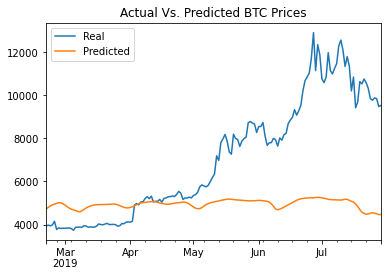

In [33]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted BTC Prices")